In [46]:
#yahoo finance as data source
#pip install yfinance
import yfinance as yf

In [47]:
import matplotlib
from datetime import datetime

#See the yahoo finance ticker for your stock symbol
stock_symbol = 'DIS'
#last 5 years data with interval of 1 day
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

df = yf.download(stock_symbol, start=start, end=end,actions=False)

type(df)

[*********************100%%**********************]  1 of 1 completed


pandas.core.frame.DataFrame

In [48]:
df1=df.reset_index()['Close']

In [49]:
df1.tail

<bound method NDFrame.tail of 0       131.669998
1       134.610001
2       134.490005
3       136.550003
4       137.839996
           ...    
1254     90.820000
1255     89.739998
1256     90.720001
1257     89.919998
1258     90.559998
Name: Close, Length: 1259, dtype: float64>

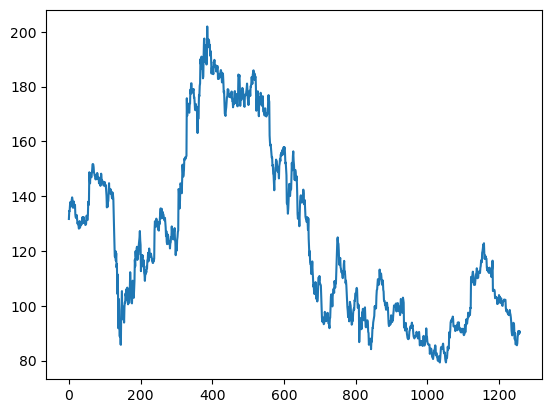

In [50]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [51]:
import numpy as np

In [52]:
df1

0       131.669998
1       134.610001
2       134.490005
3       136.550003
4       137.839996
           ...    
1254     90.820000
1255     89.739998
1256     90.720001
1257     89.919998
1258     90.559998
Name: Close, Length: 1259, dtype: float64

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape

(1259, 1)

In [54]:
print(df1)

[[0.42703317]
 [0.45101557]
 [0.45003674]
 ...
 [0.09299291]
 [0.08646707]
 [0.09168772]]


In [55]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [56]:
training_size,test_size

(818, 441)

In [57]:
train_data

array([[0.42703317],
       [0.45101557],
       [0.45003674],
       [0.4668407 ],
       [0.47736353],
       [0.47263229],
       [0.46488291],
       [0.47777142],
       [0.4855208 ],
       [0.49131252],
       [0.48543927],
       [0.46064109],
       [0.46390408],
       [0.47459008],
       [0.4788319 ],
       [0.46072275],
       [0.46488291],
       [0.46888002],
       [0.44032957],
       [0.43192759],
       [0.43347749],
       [0.42948038],
       [0.43861649],
       [0.42377031],
       [0.41308431],
       [0.41602093],
       [0.4097398 ],
       [0.40639529],
       [0.39831954],
       [0.41561304],
       [0.42075204],
       [0.40092993],
       [0.40794519],
       [0.40802672],
       [0.41357372],
       [0.41096334],
       [0.41145275],
       [0.4204258 ],
       [0.43274324],
       [0.42067051],
       [0.41553139],
       [0.43298795],
       [0.4226283 ],
       [0.41553139],
       [0.42075204],
       [0.41773389],
       [0.40916873],
       [0.410

In [58]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [59]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [60]:
print(X_train.shape), print(y_train.shape)

(717, 100)
(717,)


(None, None)

In [61]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [62]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [63]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [64]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

C:\Users\sonam\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [65]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.1695 - val_loss: 0.0095
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0173 - val_loss: 0.0178
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0090 - val_loss: 0.0038
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0055 - val_loss: 0.0013
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

In [67]:
import tensorflow as tf

In [68]:
tf.__version__

'2.17.0'

In [69]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [70]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [71]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

144.27531434340585

In [72]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

97.79640690945207

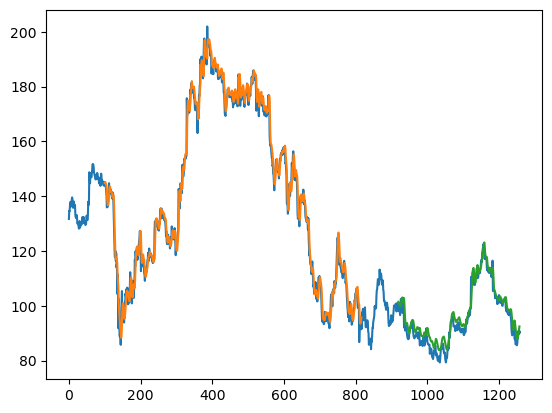

In [73]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [74]:
len(test_data)

441

In [75]:
x_input=test_data[340:].reshape(1,0-1)
x_input.shape

(1, 101)

In [76]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [77]:
temp_input
len(temp_input)

101

In [78]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.32351744 0.30810013 0.31862302 0.31022104 0.31527857 0.30891591
 0.30858961 0.28297578 0.27432903 0.2819153  0.27424751 0.27008728
 0.27155559 0.26649806 0.28052858 0.2822416  0.27286072 0.27253449
 0.26723225 0.25923809 0.25418062 0.27163718 0.28012075 0.30304267
 0.21266008 0.21306797 0.21600459 0.215923   0.2162493  0.21233378
 0.191288   0.19618242 0.19520352 0.19234849 0.19324579 0.19332732
 0.17407622 0.1830492  0.18859615 0.17587076 0.18255972 0.20058735
 0.191288   0.19585612 0.18092829 0.17856268 0.18125459 0.19104329
 0.17578924 0.17521823 0.16942651 0.16844768 0.18109141 0.18092829
 0.18370174 0.18720937 0.18484381 0.18663836 0.18647524 0.18639365
 0.16290073 0.15270414 0.15229625 0.15735378 0.15229625 0.14723878
 0.14462846 0.14397586 0.14095765 0.14528099 0.14316015 0.15621177
 0.1467493  0.14250755 0.13394239 0.12080918 0.09478752 0.08548824
 0.08067541 0.08654866 0.10457622 0.11803573 0.11722002 0.11199937
 0.08361204 0.06901051 0.08687496 0.05416428 0.054

In [83]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [84]:
import matplotlib.pyplot as plt

In [85]:
len(df1)

1259

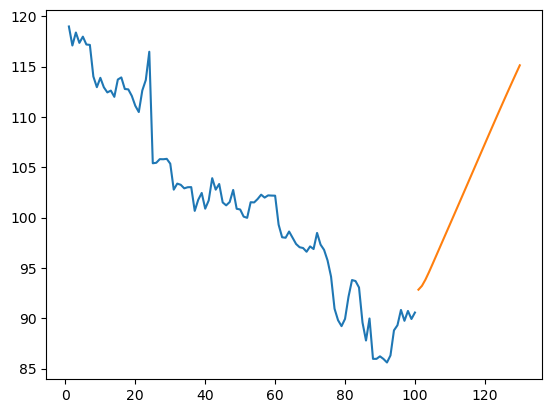

In [86]:
plt.plot(day_new,scaler.inverse_transform(df1[-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [ ]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [ ]:
df3=scaler.inverse_transform(df3).tolist()

In [ ]:
plt.plot(df3)